
# Análisis de declinación

Analisis y pronostico de productividad de pozos. 

In [2]:
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats

In [27]:
pd.set_option('display.max_rows', 1_000_000)
pd.set_option('display.max_columns', 1_000_000)
pd.set_option('display.width', 1_000_000)

<div class="alert alert-block alert-danger">

### <b>Check Harmonic Equation</b>
<br>
· b should be = 1, check bounds argument in harmonic_equation
<br>

</div>

In [4]:
import timeit
tic=timeit.default_timer()

def read_in_csv(file_path):
    """
    Read in the specified csv as a pandas dataframe
    Arguments: 
        file_path: String. Path for the csv file that we want to read in
    Outputs:
        dataframe: Pandas dataframe.
    """
    well_data=pd.read_csv(file_path,parse_dates=True)
    return well_data

def remove_nan_and_zeroes_from_columns(df, variable):
    """
    This function cleans up a dataframe by removing rows in a specific 
    column that are null/NaN or equal to 0. This basically removes zero 
    production time periods.
    Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
    Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
    """
    filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
    return filtered_df

def generate_time_delta_column(df, time_column, date_first_online_column):
    """
    Create column for the time that a well has been online at each reading, with 
    the first non-null month in the series listed as the start of production
    Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
    Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
    """
    df['Dias Produciendo']=(df[time_column]-df[date_first_online_column]).dt.days
    return (df[time_column]-df[date_first_online_column]).dt.days

def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
    global value
    """
    This function obtains the min or max value for a column, with a group by applied. For example,
    it could return the earliest (min) RecordDate for each API number in a dataframe 
    Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
    Outputs:
        value: Depends on the calc_column type.
    """
    value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
    return value

def get_max_initial_production(df, number_first_months, variable_column, date_column):
    global df_beginning_production
    """
    This function allows you to look at the first X months of production, and selects 
    the highest production month as max initial production
    Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
    """
    #First, sort the data frame from earliest to most recent prod date
    df=df.sort_values(by=date_column)
    #Pull out the first x months of production, where number_first_months is x
    df_beginning_production=df.head(number_first_months)
    #Return the max value in the selected variable column from the newly created 
    #df_beginning_production df
    return df_beginning_production[variable_column].max()

def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))

def exponential_equation(t, qi, di):
    """
    Exponential decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi*np.exp(-di*t)

def harmonic_equation (t, qi, di):
    """
    Harmonic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/(1+(di*t))

def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
    """
    This function is used to map x- and y-variables against each other
    Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
    """
    #Plot results
    df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5))
    plt.show()

def main(file_path):
    global well_data
    global production_time_series
    global results
    results=pd.DataFrame()
    #Read in the monthly oil and gas data
    #file_path=r'/Users/fffte/Documents/GitHub/Ainda/Proyecto Newton/02_productividad/kumaza_produccion.csv'
    well_data=read_in_csv(file_path)
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='gasto_aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['inicio_produccion_aceite']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                  calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='inicio_produccion_aceite')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='2016-01-01') & (well_data.fecha<='2019-12-01')]
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 6, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,10]))
        #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online'], 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,10]))
        #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', b='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)
        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        results=results.append(production_time_series)
        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon, "Hyperbolic_Predicted", "Exponential_Predicted","Harmonic_Predicted"]
        x_variable='days_online'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        #plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)
                
if __name__== "__main__":
    main(r'C:\Users\elias\Google Drive\python\csv\benchmark\kumaza_produccion.csv')

toc=timeit.default_timer()
toc - tic #elapsed time in seconds

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

C:\Users\elias\Anaconda\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\elias\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\elias\Anaconda\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeW

103.67781820000002

In [5]:
display(results.head(),results.shape)
unique_well_list=pd.unique(list(results.pozo))
display(unique_well_list.shape, len(unique_well_list))

,fecha,campo,yacimiento,plataforma,pozo,inicio_produccion_aceite,ultima_produccion_aceite,gasto_aceite_Mbd,gasto_agua_Mbd,gasto_gas_MMpcd,...,nivel_CGA,cima_mv -nivel_CGA,estatus,arriba_abajo_CGA,campo_yacimiento,Dias Produciendo,days_online,Exponential_Predicted,Hyperbolic_Predicted,Harmonic_Predicted
0,2016-01-31,KU,KU_CCE,KU-A,KU-10,2016-01-31,31/01/16,1.217011,0.008647,2.300103,...,2919.2,-334.2,OPERANDO,ARRIBA,Ku-Crétacico,0,0,1.216862e+00,0.604769,0.605825
178,2016-02-29,KU,KU_CCE,KU-A,KU-10,2016-01-31,29/02/16,0.149891,0.008873,0.278601,...,2924.518217,-339.518217,OPERANDO,ARRIBA,Ku-Crétacico,29,29,1.295811e-63,0.599056,0.599913
357,2016-03-31,KU,KU_CCE,KU-A,KU-10,2016-01-31,31/03/16,0.435305,0.095450,0.897108,...,2918.6,-333.6,OPERANDO,ARRIBA,Ku-Crétacico,60,60,6.264651e-131,0.593057,0.593719
538,2016-04-30,KU,KU_CCE,KU-A,KU-10,2016-01-31,30/04/16,0.443587,0.033466,0.969067,...,2918.6,-333.6,OPERANDO,ARRIBA,Ku-Crétacico,90,90,4.494948e-196,0.587355,0.587846
719,2016-05-31,KU,KU_CCE,KU-A,KU-10,2016-01-31,31/05/16,0.449856,0.067082,0.982420,...,2923.5,-338.5,OPERANDO,ARRIBA,Ku-Crétacico,121,121,2.173101e-263,0.581567,0.581898


(7328, 30)

(222,)

222

count    7328.000000
mean        4.663685
std         2.722959
min         0.001328
25%         2.568975
50%         4.459376
75%         6.365696
max        16.271644
Name: gasto_aceite_Mbd, dtype: float64

0.1    1.197438
0.5    4.459376
0.9    8.356293
Name: gasto_aceite_Mbd, dtype: float64

count    7328.000000
mean        4.453661
std         2.225064
min         0.033567
25%         2.772432
50%         4.304632
75%         5.743804
max        12.800735
Name: Hyperbolic_Predicted, dtype: float64

0.1    1.704135
0.5    4.304632
0.9    7.532802
Name: Hyperbolic_Predicted, dtype: float64

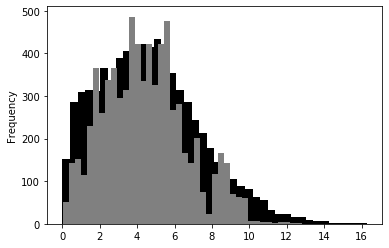

In [12]:
display(results.gasto_aceite_Mbd.describe(),
        results.gasto_aceite_Mbd.quantile([.1,.5,.9]),
        results.Hyperbolic_Predicted.describe(),
        results.Hyperbolic_Predicted.quantile([.1,.5,.9]))
results.gasto_aceite_Mbd.plot.hist(bins=40,color='black'),
results.Hyperbolic_Predicted.plot.hist(bins=40,color='gray')

count    7328.000000
mean        3.662449
std         5.254861
min         0.000413
25%         1.239010
50%         2.116109
75%         3.523018
max        64.574833
Name: gasto_gas_MMpcd, dtype: float64

0.1    0.653218
0.5    2.116109
0.9    7.483920
Name: gasto_gas_MMpcd, dtype: float64

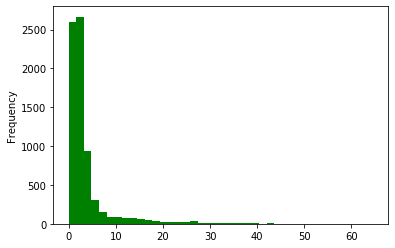

In [7]:
display(results.gasto_gas_MMpcd.describe(),
       results.gasto_gas_MMpcd.quantile([.1,.5,.9]))
results.gasto_gas_MMpcd.plot.hist(bins=40,color='green')

array([0.88819998, 0.55957469, 0.66832947, ..., 0.99997463, 0.98888252,
       0.98888839])

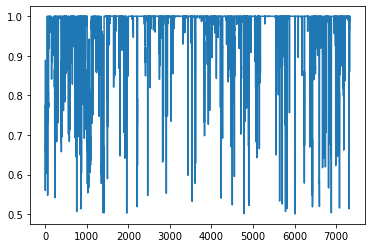

In [24]:
cdf=stats.norm.cdf(results.gasto_aceite_Mbd)

display(cdf)

plt.plot(cdf)

In [19]:
cdf.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [14]:
scipy.info(stats)

Statistical functions (:mod:`scipy.stats`)

.. module:: scipy.stats

This module contains a large number of probability distributions as
well as a growing library of statistical functions.

Each univariate distribution is an instance of a subclass of `rv_continuous`
(`rv_discrete` for discrete distributions):

.. autosummary::
   :toctree: generated/

   rv_continuous
   rv_discrete
   rv_histogram

Continuous distributions

.. autosummary::
   :toctree: generated/

   alpha             -- Alpha
   anglit            -- Anglit
   arcsine           -- Arcsine
   argus             -- Argus
   beta              -- Beta
   betaprime         -- Beta Prime
   bradford          -- Bradford
   burr              -- Burr (Type III)
   burr12            -- Burr (Type XII)
   cauchy            -- Cauchy
   chi               -- Chi
   chi2              -- Chi-squared
   cosine            -- Cosine
   crystalball       -- Crystalball
   dgamma            -- Double Gamma
   dweibull          -- Double

## DCA - UK